#Libraries and Dates

In [28]:
#Install libraries
!pip install yfinance
!pip install tfcausalimpact

In [29]:
#Import libraries
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
#Dates
training_start = "2020-09-01"
training_end = "2020-10-19"
treatment_start = "2020-10-20"
treatment_end = "2020-10-23"
end_stock = "2020-10-24"

#Loading Financial Data

In [31]:
#Bitcoin
y = ["BTC-USD"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1d")
y = y['Adj Close'].rename("y")
y[:1]

[*********************100%%**********************]  1 of 1 completed


Date
2020-09-01    11970.478516
Name: y, dtype: float64

In [32]:
#Load more stock data
stocks = ["CARL-B.CO", "ZAL.DE", "SQ", "CRSP", "TRMB", "JD", "DE", "KTOS", "GOOG"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")
X.head()

[*********************100%%**********************]  9 of 9 completed


Adj Close                         ...      Volume                   
             CARL-B.CO       CRSP          DE  ...          SQ       TRMB  ZAL.DE
Date                                           ...                               
2020-09-01  794.451111  93.419998  209.291962  ...  12306400.0   542300.0  790198
2020-09-02  802.765198  93.930000  208.734360  ...  11214800.0   728800.0  496554
2020-09-03  818.099915  85.690002  202.677399  ...  16421200.0  1220300.0  736259
2020-09-04  804.612732  82.019997  203.186935  ...  17995200.0   914700.0  662250
2020-09-07  812.926697        NaN         NaN  ...         NaN        NaN  362062

[5 rows x 54 columns]

In [33]:
#Getting just the adjusted close
X = X.iloc[:, :len(stocks)]
X.head(1)

Adj Close                         ...                          
             CARL-B.CO       CRSP          DE  ...          SQ   TRMB ZAL.DE
Date                                           ...                          
2020-09-01  794.451111  93.419998  209.291962  ...  166.660004  53.41   77.0

[1 rows x 9 columns]

In [34]:
#Removing unneded level
X.columns = X.columns.droplevel()
X.head(1)

,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-01,794.451111,93.419998,209.291962,83.0355,79.267685,19.700001,166.660004,53.41,77.0


In [35]:
#Combine everything
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2020-09-01,11970.478516,794.451111,93.419998,209.291962,83.035500,79.267685,19.700001,166.660004,53.410000,77.000000
2020-09-02,11414.034180,802.765198,93.930000,208.734360,86.414001,79.959557,19.910000,162.880005,54.310001,77.000000
2020-09-03,10245.296875,818.099915,85.690002,202.677399,82.092003,75.952454,19.520000,152.860001,50.900002,75.080002
2020-09-04,10511.813477,804.612732,82.019997,203.186935,79.552002,76.874954,19.260000,146.389999,49.959999,71.739998
2020-09-08,10131.516602,799.439575,81.459999,202.129379,76.619499,73.242615,19.230000,139.110001,49.139999,73.440002


#Data Analysis

In [36]:
#Prepare Dataframe with only Training Data
df_training = df[df.index <= training_end]
df_training.tail()

,y,CARL-B.CO,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,,
2020-10-13,11425.899414,827.891968,103.059998,228.852371,78.584000,79.383003,20.959999,190.470001,51.720001,85.820000
2020-10-14,11429.506836,822.718811,101.370003,230.058258,78.403999,77.931984,21.010000,187.490005,50.540001,84.980003
2020-10-15,11495.349609,808.492615,99.889999,229.836380,77.956497,77.115189,21.100000,188.600006,52.290001,84.419998
2020-10-16,11322.123047,801.656616,109.830002,231.592194,78.650497,78.335571,20.790001,186.350006,52.340000,84.800003
2020-10-19,11742.037109,804.427917,107.720001,229.768814,76.730499,77.461121,20.639999,186.960007,51.970001,85.000000


In [44]:
#Differencing
differencing = df_training.pct_change().dropna()

#Stationarity
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = differencing.y)[1]
print(test)

#ifelse
if test < 0.05:
  print("The time series is stationary")
else:
  print("The time series is not stationary")

3.8054323617260893e-07
The time series is stationary


<Axes: >

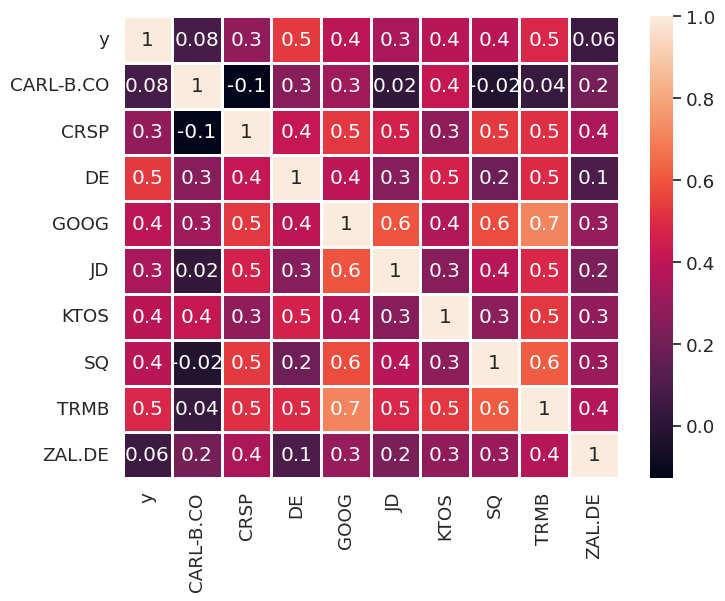

In [48]:
#Correlation matrix
plt.figure(figsize = (8,6))
sns.set(font_scale=1.2)
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            linewidths = 1,
            linecolor = 'white')

#Google Causal Impact

In [50]:
#Prepare the dataset
df_final = df.drop(columns = ["CARL-B.CO", "ZAL.DE"])
df_final.head(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,209.291962,83.0355,79.267685,19.700001,166.660004,53.41


In [56]:
#Prepare pre and post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

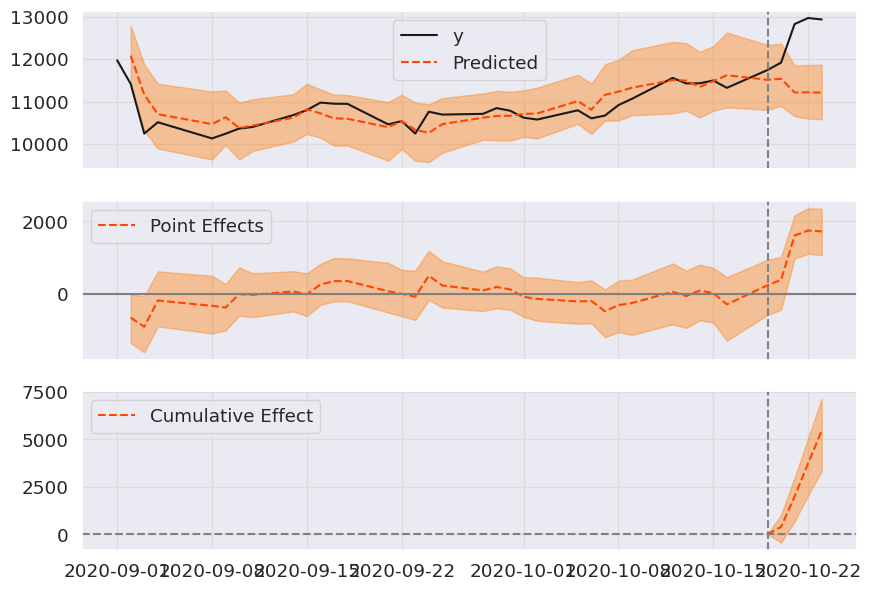

In [58]:
#Google Causal Impact
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)
impact.plot()

In [59]:
#Summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11293.4 (255.02)   45173.62 (1020.09)
95% CI                    [10858.81, 11858.49][43435.25, 47433.95]

Absolute effect (s.d.)    1365.96 (255.02)   5463.84 (1020.09)
95% CI                    [800.88, 1800.55]  [3203.51, 7202.2]

Relative effect (s.d.)    12.1% (2.26%)      12.1% (2.26%)
95% CI                    [7.09%, 15.94%]    [7.09%, 15.94%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Cummulative = refer to bottom graph
Posterio tail-area (p value) = 0 ( means result very significant)


In [60]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 11293.4.
The 95% interval of this counterfactual prediction is [10858.81, 11858.49].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1365.96 with a 95% interval of
[800.88, 1800.55]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 45173.62. The 95% interval of this prediction is [43435.25, 47433.95].


The above results are given in terms of absolute numbers. In relative
te